In [2]:
# Import necessary libraries
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import sklearn.model_selection as model_selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

In [3]:
data = pd.read_csv("Data_comp.csv")

X = data.drop(['Image', 'Category'], axis = 1)
y = data['Category']

# Divide data into training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

In [4]:
print(f"Dimensions of the X train: {X_train.shape}")
print(f"Dimensions of the X test: {X_test.shape}")
print(f"Dimensions of the Y train: {y_train.shape}")
print(f"Dimensions of the Y test: {y_test.shape}")

Dimensions of the X train: (2611, 14)
Dimensions of the X test: (653, 14)
Dimensions of the Y train: (2611,)
Dimensions of the Y test: (653,)


In [5]:
# Frequency distribution of classes
train_outcome = pd.crosstab(index=data["Category"],  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome

col_0,count
Category,
glioma_tumor,926
meningioma_tumor,937
no_tumor,500
pituitary_tumor,901


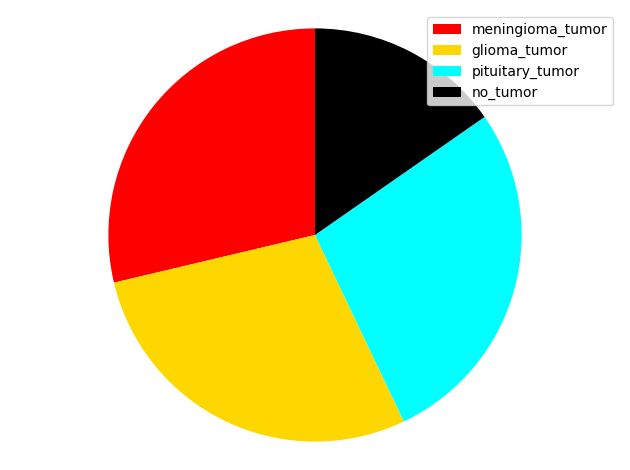

In [6]:
# Visualizing Outcome Distribution 
temp = data["Category"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

labels = df['labels']
sizes = df['values']
colors = ['red', 'gold', 'cyan', 'black']
patches, texts = plt.pie(sizes, colors=colors, shadow=False, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()

# Save Figure
#plt.savefig('Distribution.jpg', dpi=600)
plt.show()

In [7]:
# Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Coding Labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Show the classes and their coded labels
for index, label in enumerate(encoder.classes_):
    print(f"Class {index}: {label}")

Class 0: glioma_tumor
Class 1: meningioma_tumor
Class 2: no_tumor
Class 3: pituitary_tumor


In [8]:
# Feature Selection
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)
X_test_selected = selector.transform(X_test_scaled)

In [9]:
feature_names = X_train.columns

# Get the indexes of the selected characteristics
selected_indices = selector.get_support(indices=True)
selected_features = feature_names[selected_indices]

i = 0
print("Selected features:")
for feature in selected_features:
    i += 1
    print(f"Feature {i}: {feature}")

Selected features:
Feature 1: Contrast
Feature 2: Dissimilarity
Feature 3: Homogeneity
Feature 4: ASM
Feature 5: Energy
Feature 6: Correlation
Feature 7: Entropy
Feature 8: Gabor
Feature 9: HOG
Feature 10: LBP


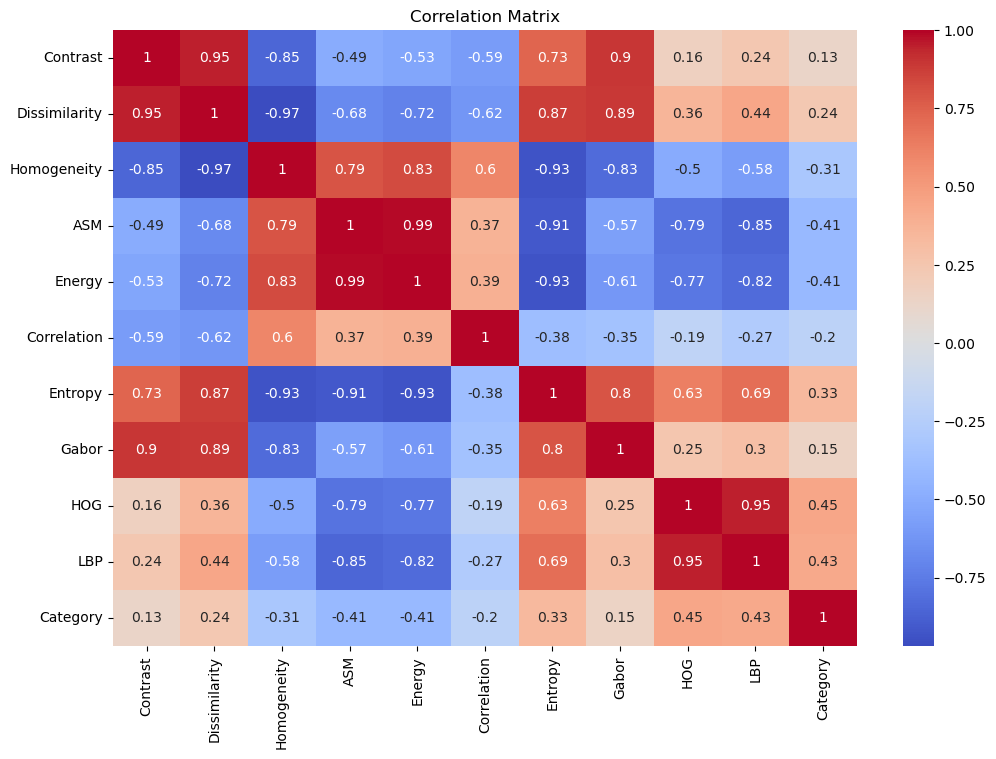

In [10]:
# Convert X_train_selected to DataFrame
X_train_df = pd.DataFrame(X_train_selected, columns=selected_features)

# Adding coded categories to the DataFrame
X_train_df['Category'] = y_train_encoded

# Calculate the correlation matrix
corr_matrix = X_train_df.corr()

# Show the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
# Save Figure
#plt.savefig('Correlation matrix.jpg', dpi=600)
plt.show()

### Hyperparameter setting

In [12]:
params_rbf = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8],
                     'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}]

In [13]:
params_poly = [{'kernel': ['poly'], 'degree': [2, 3, 4, 5], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], 
                     'coef0': [0, 1, 2]}]

In [14]:
params_linear = [{'kernel': ['linear'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}]

In [15]:
params_sigmoid = [{'kernel': ['sigmoid'], 'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000], 'coef0': [0, 1, 2]}]

In [16]:
# Stratified cross-validation
cv = StratifiedKFold(n_splits=10)

In [17]:
# Create and train the model
svm_model = GridSearchCV(SVC(), params_rbf, cv=cv)
svm_model.fit(X_train_selected, y_train_encoded)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
                          'gamma': [0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08],
                          'kernel': ['rbf']}])

In [18]:
# Predicting labels for the test set
y_pred = svm_model.predict(X_test_selected)

In [19]:
# Calculate and display confusion matrix and ranking report
cm = confusion_matrix(y_test_encoded, y_pred)
print(cm)

print(classification_report(y_test_encoded, y_pred))

[[129  44   6  21]
 [ 34 121  17  17]
 [  7  21  61   7]
 [ 16   5   4 143]]
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       200
           1       0.63      0.64      0.64       189
           2       0.69      0.64      0.66        96
           3       0.76      0.85      0.80       168

    accuracy                           0.70       653
   macro avg       0.70      0.69      0.69       653
weighted avg       0.69      0.70      0.69       653



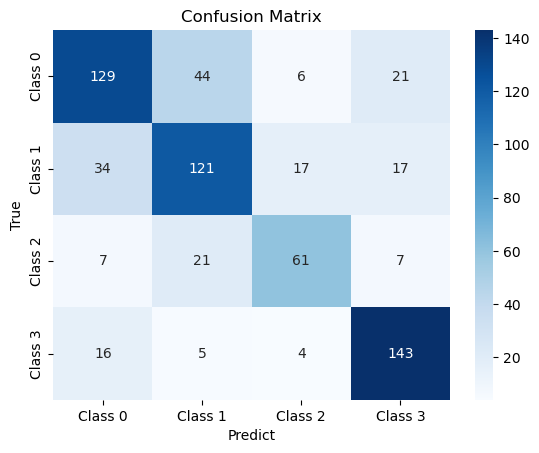

In [20]:
# Creating a figure and a set of subplots
fig, ax = plt.subplots()

# Create a heat map
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')

# Labels, títles and ticks
ax.set_xlabel('Predict')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])
ax.yaxis.set_ticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# Save Figure
#plt.savefig('confusion_matrix_rbf.jpg', dpi=600)

In [21]:
# Converting labels to two-dimensional arrays
y_test_binarized = label_binarize(y_test_encoded, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2, 3])

# Calculate and display ROC-AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_binarized, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7942339283368836


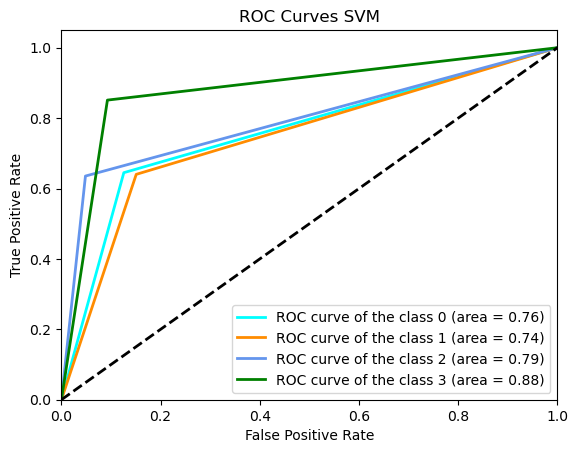

In [22]:
# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of the class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves SVM')
plt.legend(loc="lower right")

# Save Figure
#plt.savefig('roc_curves_rbf.jpg', dpi=600)
plt.show()

In [23]:
# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")
print('Best Coef0:',svm_model.best_estimator_.coef0,"\n")
print('Best Degree:',svm_model.best_estimator_.degree,"\n")

Best C: 100000 

Best Kernel: rbf 

Best Gamma: 0.001 

Best Coef0: 0.0 

Best Degree: 3 

